# Fine-tuning

This notebook will use a pre-trained ResNet 18 model to train a new set of images the have been used to predict the 2018 "Campfire" set of fire during the 2018 California fire season - based on 2016 and 2017 aerial photos.

These aerial photos are stored in a folder structure  as follows:

### Folder structure for images
<figure>
<img src="assets/FolderStructure.jpg" width="400">
<figcaption align = "center">  </figcaption>
</figure>

Due to the sort order, 'Fire' comes before 'NoFire' so the class index is as follows:

- 0: Fire
- 1: NoFire

While I have created a custom kernel for this class to access the GPU - there is a standard kernel Intel provides (without the support libraries such as pandas, and seaborn, etc) called **pytorch_xpu** that I would recommend for quick testing of a PyTorch model.


## Fine-tuning is awesome! 

<figure>
<img src="assets/fine_tuning.png" width="800">
<figcaption align = "center"> Figure 1. Fine-tuning in a nutshell. </figcaption>
</figure>

Fine-tuning allows me to train a small number of iterations of a small number of images to create a custom model quickly.  It does this by freezing most of the layers of a pre-trained model such as ResNet and allowing me to train just the very last layers.

As a result, this notebook can be run quite fast on Intel(r) 4th generation Xeon(r) Scalable processors!  But it can also be run even faster on out Intel(r) 1100 GPU MAX Series GPU.

I will be demonstrating how to train against the new Intel(r) GPUs in this exercise - taking advantage of a key ingredient supplied by the Intel(R) Extensions for PyTorch




Click here to learn more about [Accelerating PyTorch* with Intel® Extension for PyTorch](https://www.intel.com/content/www/us/en/developer/articles/technical/accelerate-with-intel-extension-for-pytorch.htm) 

# Intel(r) Extension for PyTorch*

### Extends PyTorch:
- The Intel® Extension for PyTorch* for GPU extends PyTorch with up-to-date features and optimizations for an extra performance boost on Intel Graphics cards.
- Intel releases its newest optimizations and features in Intel® Extension for PyTorch* before up-streaming them into open source PyTorch.
- There are two versions of Intel Extensions for PyTorch:
  1) for XPU
  2) for CPU
- [Intel(r) Extension for PyTorch](https://www.intel.com/content/www/us/en/developer/articles/technical/introducing-intel-extension-for-pytorch-for-gpus.html#gs.3y2glt)


### Inference Cheat-sheet:

| **Inference on CPU** | **Inference on XPU** |
| --- | --- |
| ![Inference CPU](assets/IPEX_Inference_CPU.png) | ![Inference XPU](assets/IPEX_Inference_XPU.png) |


## Summary of advantage of fine-tuning

- Target datasets are much smaller than source datasets

- Fine-tuning helps to improve the model's generalization ability.

- Can be trained faster with fewer resources and fewer images.

## Exercise 1: import
### Hint: replace broken code line with this code:

```python
import intel_extension_for_pytorch
```

In [2]:
# %load fine_tune.py
import os
#os.environ["WANDB_DIR"] = "wandb_logs/"
#import pathlib
import warnings
#import random
import time
import gc
from typing import Tuple
#import glob
from PIL import Image
from os.path import exists
import os
warnings.filterwarnings("ignore")

import torch
#****************************************
import intel_extension_for_pytorch
#Insert code for Intel Extensions for PyTorch Here
#****************************************
import numpy as np
import matplotlib.pyplot as plt
#import wandb
import seaborn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from batch_finder import optimum_batch_size
from config import set_seed, device
from data_loader import (
    TRAIN_DIR,
    VALID_DIR,
    augment_and_save,
    data_distribution,
    imagenet_stats,
    img_transforms,
    plot_data_distribution,
    show_data,
)
from metrics import Metrics
from model import FireFinder
from trainer import Trainer
from lr_finder import LearningRateFinder
from torch import optim



def create_dataloader(
    directory: str, batch_size: int, shuffle: bool = False, transform=None
) -> DataLoader:
    """
    Create a DataLoader from a directory of images.

    Args:
        directory (str): Directory containing images.
        batch_size (int): Batch size for the DataLoader.
        shuffle (bool, optional): Whether to shuffle the data. Defaults to False.
        transform ([type], optional): Transformations to apply to the images. Defaults to None.

    Returns:
        DataLoader: DataLoader with images from the directory.
    """
    data = datasets.ImageFolder(directory, transform=transform)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)


def setup_dataloaders(config: dict) -> Tuple[DataLoader, DataLoader]:
    """
    Setup train and validation DataLoaders.

    Args:
        config (dict): Configuration dictionary containing batch_size.

    Returns:
        Tuple[DataLoader, DataLoader]: A tuple containing train and validation dataloaders.
    """
    return create_dataloader(
        TRAIN_DIR, config["batch_size"], shuffle=True, transform=img_transforms["train"]
    ), create_dataloader(
        VALID_DIR, config["batch_size"], transform=img_transforms["valid"]
    )


def find_lr(model: FireFinder, optimizer: optim.Adam, dataloader: DataLoader) -> float:
    """
    Find best learning rate using Learning Rate Finder.

    Args:
        model (FireFinder): FireFinder model.
        optimizer (optim.Adam): Adam optimizer.
        dataloader (DataLoader): DataLoader with training data.

    Returns:
        float: Best learning rate.
    """
    lr_finder = LearningRateFinder(model, optimizer, device)
    best_lr = lr_finder.lr_range_test(dataloader, start_lr=1e-2, end_lr=1e-5)
    return best_lr


def train(model: FireFinder, trainer: Trainer, config: dict):
    """
    Train a FireFinder model.

    Args:
        model (FireFinder): FireFinder model.
        trainer (Trainer): Trainer to train the model.
        config (dict): Configuration dictionary containing learning rate and batch size.
    """
    train_dataloader, valid_dataloader = setup_dataloaders(config)
    print("training data")
    plot_data_distribution(data_distribution(train_dataloader.dataset, TRAIN_DIR))
    print("\nvalidation data")
    plot_data_distribution(data_distribution(valid_dataloader.dataset, VALID_DIR))
    print(f"______________")
    start = time.time()
    val_acc = trainer.fine_tune(train_dataloader, valid_dataloader)
    model_save_path = f"./models/model_acc_{val_acc}_device_{device}_lr_{trainer.lr}_epochs_{EPOCHS}.pt"
    torch.save(model.state_dict(), model_save_path)

    model.eval()
    with torch.no_grad():
        model_scripted = torch.jit.script(model)  # Export to TorchScript
        model_scripted.save(f"{model_save_path.replace('.pt','_jit.pt')}")  # Jit Save

    print(f"Model saved to :{model_save_path}")
    print(f"Time elapsed: {time.time() - start} seconds.")
    return (model_save_path)

# Exercise 2A: Add `_to_ipex` method to Trainer Class located in **`trainer.py`**

Replace Broken code with:

```python
#*************************** Exercise 2 ***************************************
    def _to_ipex(self, dtype=torch.float32):
        """convert model memory format to channels_last to IPEX format."""
        self.model.train()
        self.model = self.model.to(memory_format=torch.channels_last)
        self.model, self.optimizer = ipex.optimize(
            self.model, optimizer=self.optimizer, dtype=torch.float32
        )
#******************************************************************************
```


# Exercise 2B: Set device to "xpu" located in **config.py**

- Edit "config.py" line 97

```pytorch
device = set_device("xpu")
```

# Training the model

Train folder data/colorEnhanced/train
Validation folder data/colorEnhanced/val
Using epoch: 10
Using Dropout: 0.3


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/u9999ad7367849478acc6568ce06912b/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.7MB/s]


Running in Finetuning mode.
Using batch size: 64
Using learning rate: 0.000214
Running in Finetuning mode.
training data


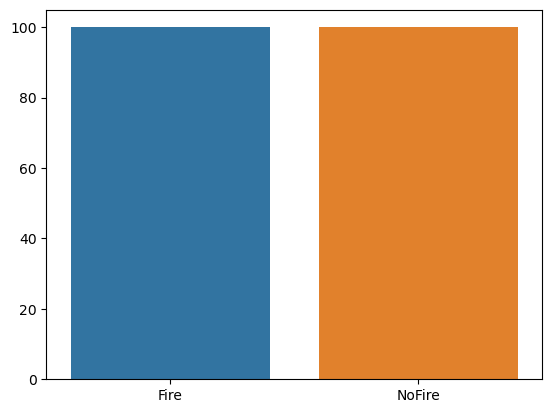


validation data


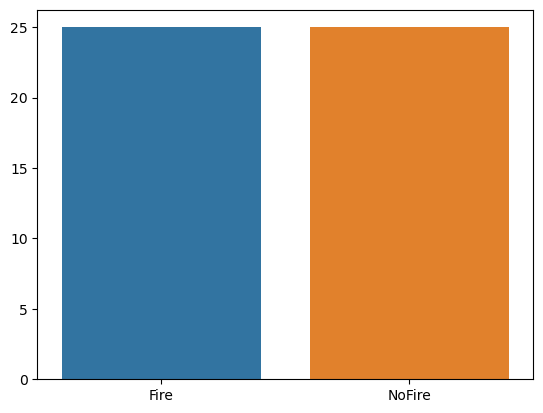

______________


100%|██████████| 1/1 [00:23<00:00, 23.35s/it]



📅 Epoch 1/10:
	🏋️‍♂️ Training step:
	 - 🎯 Loss: 0.3979, 📈 Accuracy: 0.7650
	🧪 Validation step:
	 - 🎯 Loss: 0.2498, 📈 Accuracy: 0.9200
⏱️ Time: 144.7226 sec



  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# hyper params
EPOCHS = 10
DROPOUT = .3
# LR would be changed if we are using a LR finder
LR = 2.14e-4
#LR = 3.e-3
TEST_DIR = 'data/colorEnhanced/'
BATCH_SIZE = 64 #128  # Default batch size

aug_data = False
find_batch = False
find_lr_rate = False
#use_wandb = False
use_ipex=True

set_seed(42)
print(f"Train folder {TRAIN_DIR}")
print(f"Validation folder {VALID_DIR}")
print(f"Using epoch: {EPOCHS}")
print(f"Using Dropout: {DROPOUT}")

batch_size = BATCH_SIZE

if aug_data:
    print("Augmenting training and validation datasets...")
    t1 = time.time()
    augment_and_save(TRAIN_DIR)
    augment_and_save(VALID_DIR)
    print(f"Done Augmenting in {time.time() - t1} seconds...")

model = FireFinder(simple=True, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=LR)
if find_batch:
    print(f"Finding optimum batch size...")
    batch_size = optimum_batch_size(model, input_size=(3, 224, 224))
print(f"Using batch size: {batch_size}")

best_lr = LR
if find_lr_rate:
    print("Finding best init lr...")
    train_dataloader = create_dataloader(
        TRAIN_DIR,
        batch_size=batch_size,
        shuffle=True,
        transform=img_transforms["train"],
    )
    best_lr = find_lr(model, optimizer, train_dataloader)
    del model, optimizer
    gc.collect()
    if device == torch.device("xpu"):
        torch.xpu.empty_cache()
print(f"Using learning rate: {best_lr}")

model = FireFinder(simple=True, dropout=DROPOUT)
trainer = Trainer(
    model=model,
    optimizer=optim.Adam,
    lr=best_lr,
    epochs=EPOCHS,
    device=device,
    #use_wandb=use_wandb,
    use_ipex=use_ipex,  # using ipex or not depending on this flag
)
model_save_path = train(model, trainer, config={"lr": best_lr, "batch_size": batch_size})

In [ ]:
print("Done!")

## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 